<a href="https://colab.research.google.com/github/Hertie-School-Machine-Learning-F2022/Class_Lab_07/blob/main/Notes_Lab_07_GRAD_C24_fall_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resampling and regularisation

GRAD-C24, Lab 07

Date: 04.11.2022



## Overfitting and Underfitting

Machine learning models can never make perfect predictions. This failure comes from a fundamental trade-off between how flexible a model can become and how much data it can see when training.

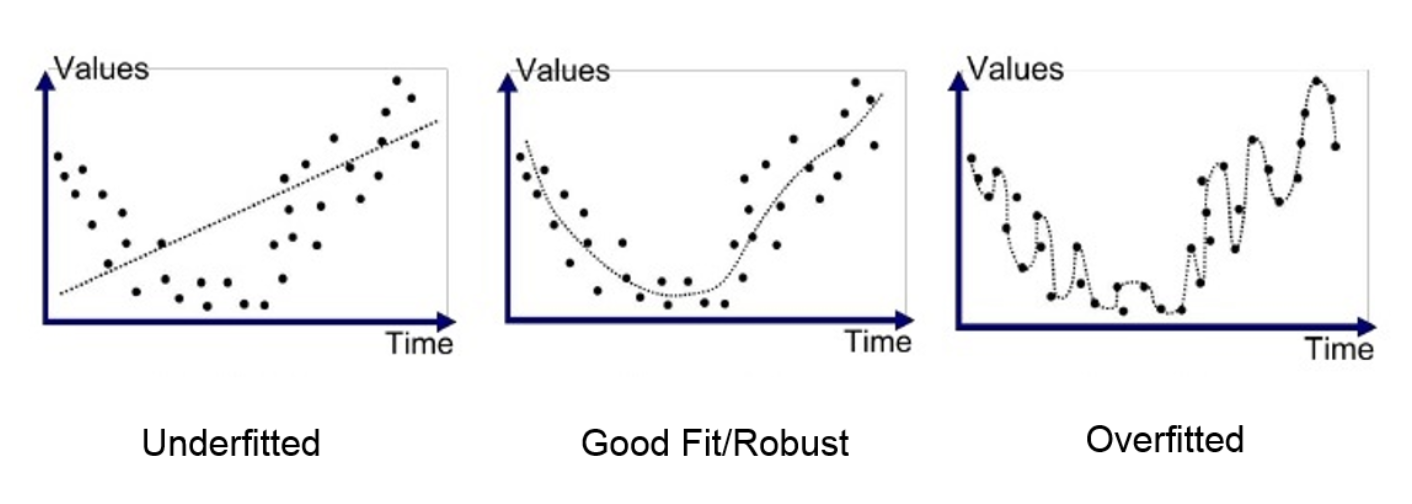

**Overfitting**

Models too complex for the data overfit:
They explain too well the data that they have seen and do not generalize.

**Underfitting**

Models too simple for the data underfit:
They capture no noise, and are limited by their expressivity.

In [ ]:
# We will use this data to explain with more detail.
# In this dataset, we want to predict the median value of houses in California.

from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame = True)

#Set data and target 
data, target = housing.data, housing.target 

In [ ]:
# Transform the target prices from 100 to thousands
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

In [ ]:
data.head()

In [ ]:
# To solve this regression task, we will use a linear regression

from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
regressor.fit(data, target)

DecisionTreeRegressor()

In [ ]:
# After training the regressor, we would like to know its potential generalization 
# performance once deployed in production.

# For this purpose, we use the mean absolute error, which gives us an error in the target's unit

from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


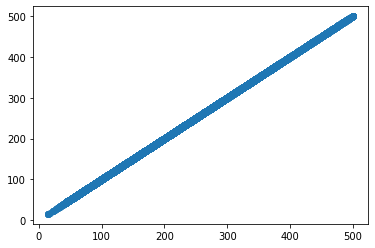

In [ ]:
#Let's plot it

import matplotlib.pyplot as plt

plt.scatter(target, target_predicted)
plt.show()

### What do we see? 

We get perfect prediction with no error. 

### Why?

When models are too optimistic, they are usually pointing towards a methodological problem in our pipeline.



In this case, the mistake lies on the fact that we trained and predicted on the same dataset. 

What all that our decision tree model did was to memorize the dataset when fitted, it will lead to an error of 0.

**This error computed above is called the *empirical error* or *training error*.**

In Machine Learning, the aim is to minimize the error on data that has not been seen, which is called the ***generalization error*** or the ***“true” testing error***.

# Resampling 

Resampling methods allow us to draw samples from a trainng set and refit a model of intrest on each sample to obtain additional information about the fitted model. 

It allows us to see how a model would perform on data it has not been trained on, without collecting new data (i.e., gives us information about the true testing error) 

## 1. Validation Set approach

Randomly divide the dataset into training and testing set (other names: validation set, hold out set).

In [ ]:
# Simple Train and Testing split 

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=0)

# Train

regressor.fit(data_train, target_train)

DecisionTreeRegressor()

In [ ]:
# First let's see the trianing error.

target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


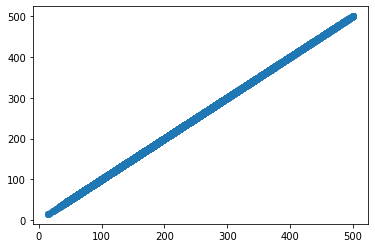

In [ ]:
# Plot

plt.scatter(target_predicted, target_train)
plt.show()

In [ ]:
# However, if we now compute the testing error using
# unseen data, we no longer have the same results.

target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.07 k$


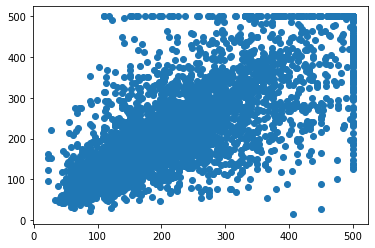

In [ ]:
# Plot

plt.scatter(target_predicted, target_test)
plt.show()

However, test error rate is highly variable depending on which observations are in the each set. 

When a small number of observations are used to fit the model, usually modeles perform worse. 

When we separete the data, we can never be sure of how biased the sample turned out. 


## 3. K-fold cross-validation

The most common approach involves randomly dividing the set of observations into k groups of the same size.

The first fold is treated as a validation set and the model is fit on the remaining folds.

The procedure is then repeated k times, where a different group is treated as the validation set.

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_validate

cv_results = cross_validate(regressor, data, target, return_estimator=True)
pd.DataFrame(cv_results)

,fit_time,score_time,estimator,test_score
0,0.421894,0.002395,DecisionTreeRegressor(),0.252380
1,0.154485,0.002389,DecisionTreeRegressor(),0.426651
2,0.150362,0.002363,DecisionTreeRegressor(),0.431796
3,0.150308,0.002160,DecisionTreeRegressor(),0.231237
4,0.144946,0.001819,DecisionTreeRegressor(),0.425253


In [ ]:
# scikit-learn provide a cross_val_score function which makes evaluation faster.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.27434422, 0.42940159, 0.42900709, 0.23325626, 0.44668141])

### How can we use training and testing error to know if our model is generalizing, overfitting or underfitting?

In [ ]:
# Using cross validate we can access the training and the testing errors.

from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(regressor, data, target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)

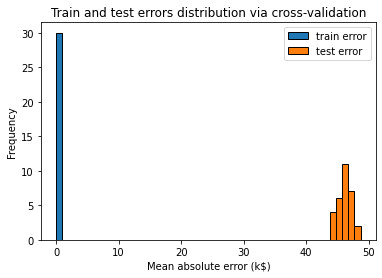

In [ ]:
# The cross-validation used the negative mean absolute error.
# We transform the negative mean absolute error into a positive 
# mean absolute error for plotting.

scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]]

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

Here, we observe a training error of zero, meaning that the model is not under-fitting: it is flexible enough to capture any variations present in the training set.

However, the testing error is bigger. This tells us that the model is over-fitting: the model has memorized many variations of the training set that could be considered “noisy” because they do not generalize to help us make good prediction on the test set.


How can we find a good point between overfitting and underfitting? 


# Regularization

Regularization is a method to prevent overfitting. 

Regularization refers to techniques that are used to calibrate machine learning models to minimize the adjusted loss function and prevent overfitting or underfitting.

In Decision Trees, for example, one can control how much a tree can "grow" by adjusting the "max_depth" parameter.

In [ ]:
# We will use a validation curve function to visualize how adjusting a paramter
# can give us less or more testing error and training error.

%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
regressor = DecisionTreeRegressor()

train_scores, test_scores = validation_curve(
    regressor, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores



CPU times: user 648 ms, sys: 57.4 ms, total: 706 ms
Wall time: 13.1 s


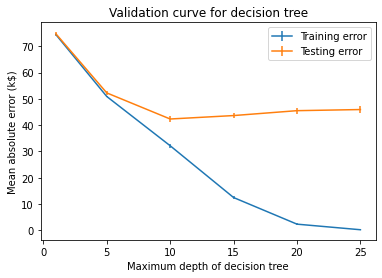

In [ ]:
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

In [ ]:
from sklearn.model_selection import GridSearchCV

gscv = GridSearchCV(estimator = regressor, param_grid = {'max_depth': [1, 5, 10, 15, 20, 25]}, cv = cv)

gscv.fit(data, target)

pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014006,0.000887,0.001404,0.000353,1,{'max_depth': 1},0.297129,0.306195,0.302380,0.296914,...,0.291643,0.291741,0.296207,0.299942,0.330532,0.272628,0.321427,0.304158,0.014046,6
1,0.056750,0.001025,0.001867,0.000472,5,{'max_depth': 5},0.623662,0.616929,0.608147,0.608848,...,0.593530,0.597429,0.600575,0.611382,0.619124,0.607076,0.627735,0.614439,0.011042,5
2,0.099238,0.001807,0.002134,0.000278,10,{'max_depth': 10},0.678164,0.703851,0.695419,0.695481,...,0.674060,0.695056,0.699034,0.704170,0.697222,0.700046,0.709407,0.699665,0.013515,1
3,0.129780,0.001423,0.002429,0.000188,15,{'max_depth': 15},0.605449,0.659300,0.639395,0.636437,...,0.630579,0.632902,0.612364,0.638850,0.650429,0.648834,0.657058,0.644419,0.018852,2
4,0.145674,0.001453,0.002918,0.000262,20,{'max_depth': 20},0.581809,0.642866,0.619951,0.602846,...,0.606595,0.618353,0.594730,0.622518,0.613555,0.624965,0.624276,0.620083,0.018953,3
5,0.151472,0.002820,0.003088,0.000168,25,{'max_depth': 25},0.572128,0.648266,0.608484,0.596681,...,0.587719,0.610575,0.591349,0.620110,0.606975,0.617850,0.615984,0.616456,0.021156,4


## More regularization!

Linear Regression and Logistic Regression use the LSM to estimate their parameters (linear models). 

We can replace least squares with other fitting procedures, given that there are situations when LS fails. 

Regularization methods such as lasso or ridge make the predictions less sensitive to small training sets by adding bias to the model.


## Lasso 

Lasso uses the absolut value of the parameter beta instead of its squared value. 
However, if lambda is large enough, some coefficients will effectively be 0! Therefore, lasso can also perform variable selection, making the model much easier to interpret.

In [ ]:
# We will use a new data set "advertising"

import io
from google.colab import files

%matplotlib inline

# load the data
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['advertising.csv']))

# look at the first two rows
data.head()

Saving advertising.csv to advertising.csv


,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [ ]:
# drop Unnamed: 0 column 

data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


This is a media studies research project: 

We want to analyze how propaganda and product placement work in right wing media, by predicting sales on three different mediums (TV, radio, newspaper).

In [ ]:
def scatter_plot(feature, target):
  plt.figure(figsize=(16, 8))
  plt.scatter(
      data[feature],
      data[target],
      c = 'black'
  )
  plt.xlabel('Money spent on {} ads ($)'.format(feature))
  plt.ylabel('Sales ($k)')
  plt.show()

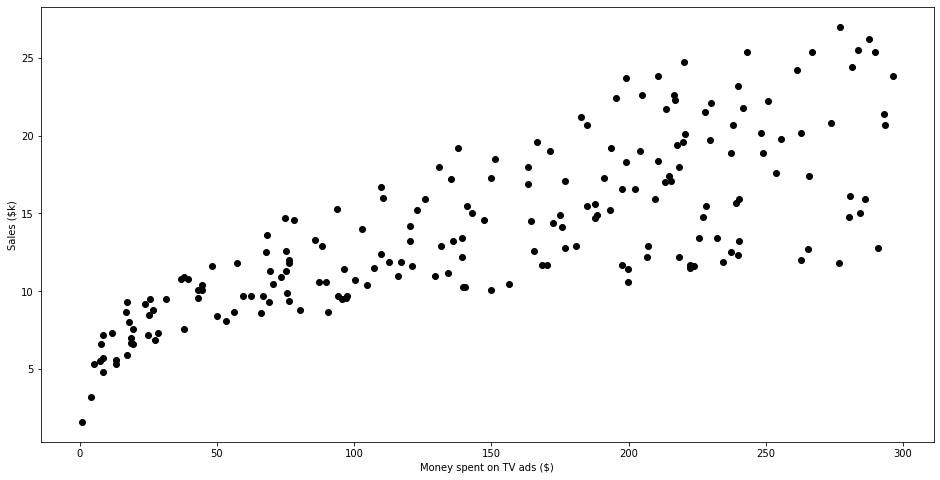

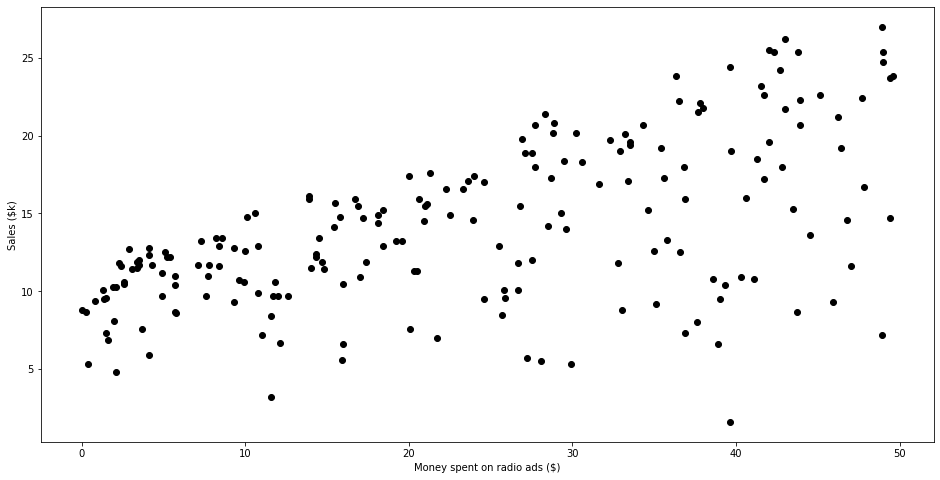

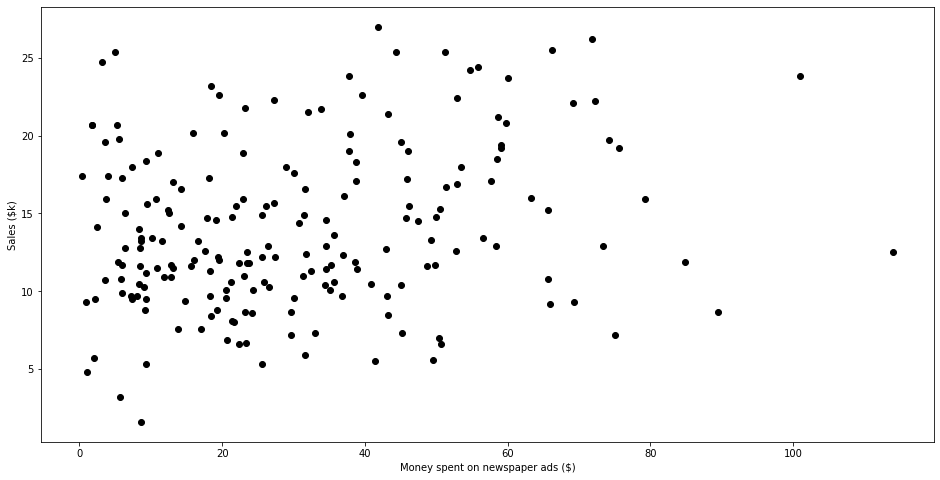

In [ ]:
scatter_plot('TV', 'sales')
scatter_plot('radio', 'sales')
scatter_plot('newspaper', 'sales')

TV and radio ads seem to be good predictors for sales, while there seems to be no correlations between sales and newspaper ads. 

In [ ]:
# For this example, we will use Multiple Linear Regression

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
X = data.drop(['sales'], axis = 1)
y = data['sales'].values.reshape(-1,1)

lin_reg = LinearRegression()

MSEs = cross_val_score(lin_reg, X, y, scoring = 'neg_mean_squared_error', cv = 5)
MSEs_r2 = cross_val_score(lin_reg, X, y, cv = 5)

mean_MSE = np.mean(MSEs)
mean_MSE_r2 = np.mean(MSEs_r2)

print(mean_MSE)
print(mean_MSE_r2)

-3.0729465971002106
0.8871063495438435


In [ ]:
# Let's do a lasso

from sklearn.linear_model import Lasso
lasso = Lasso(max_iter = 10000)

parameters = {'alpha' : [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv=5)

lasso_regressor.fit(X, y)


print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
pd.DataFrame(lasso_regressor.cv_results_)

{'alpha': 1}
-3.041405896751369


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002052,0.001278,0.001062,0.000107,0.0,{'alpha': 1e-07},-3.136540,-2.425668,-1.585225,-5.426155,-2.791145,-3.072947,1.284783,7
1,0.001482,0.000122,0.000993,0.000024,0.000001,{'alpha': 1e-06},-3.136540,-2.425668,-1.585225,-5.426155,-2.791145,-3.072947,1.284783,6
2,0.001599,0.000180,0.001049,0.000057,0.00001,{'alpha': 1e-05},-3.136539,-2.425668,-1.585225,-5.426153,-2.791146,-3.072946,1.284782,5
3,0.001364,0.000012,0.001010,0.000074,0.0001,{'alpha': 0.0001},-3.136535,-2.425666,-1.585222,-5.426135,-2.791154,-3.072942,1.284776,4
4,0.001369,0.000031,0.001005,0.000048,0.001,{'alpha': 0.001},-3.136492,-2.425652,-1.585195,-5.425954,-2.791229,-3.072904,1.284713,3
5,0.001378,0.000017,0.000976,0.000011,0.01,{'alpha': 0.01},-3.136061,-2.425572,-1.584922,-5.424177,-2.791971,-3.072541,1.284097,2
6,0.001559,0.000206,0.001017,0.000058,1,{'alpha': 1},-3.095589,-2.421105,-1.569642,-5.247793,-2.872900,-3.041406,1.220683,1
7,0.001394,0.000042,0.000979,0.000014,5,{'alpha': 5},-3.104720,-2.529290,-1.655089,-5.029377,-3.299919,-3.123679,1.111140,8
8,0.001370,0.000013,0.000963,0.000011,10,{'alpha': 10},-3.361207,-2.863476,-1.991244,-5.075305,-4.076201,-3.473487,1.049843,9


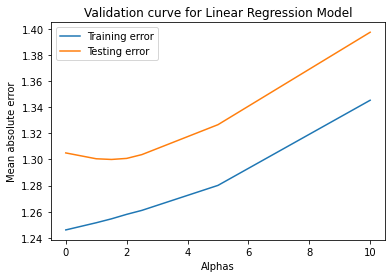

In [ ]:
# Let's take a look at the curves

alpha = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1, 1.5, 2, 2.5, 5, 10]
regressor = Lasso()

train_scores, test_scores = validation_curve(
    regressor, X, y, param_name="alpha", param_range=alpha,
    cv=5, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

plt.plot(alpha, train_errors.mean(axis=1), label="Training error")
plt.plot(alpha, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Alphas")
plt.ylabel("Mean absolute error")
_ = plt.title("Validation curve for Linear Regression Model")